In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [2]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [3]:
y = train['price']
del train['price']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [4]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


<AxesSubplot:xlabel='price', ylabel='Density'>

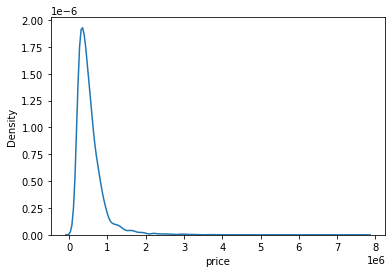

In [5]:
sns.kdeplot(y)

In [6]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

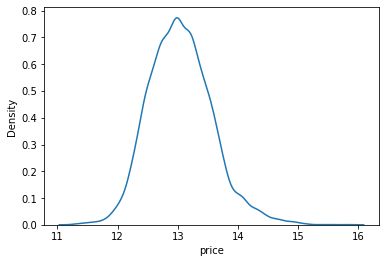

In [8]:
sns.kdeplot(y)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [10]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [11]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [12]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df =pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [13]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) :
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(results['score'] *-1)
    results = results.sort_values(['RMSLE'])
    
    return results

In [14]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [15]:
def save_submission(model, train, y, test, model_name, rmsle) :
    #1. 모델을 `train`, `y`로 학습시킵니다. 
    model.fit(train, y)
    #2. `test`에 대해 예측합니다.
    prediction = model.predict(test)
    #3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [16]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


하이퍼 파라미터 max_dedpth 10, n_estimators 100 으로 케글에 제출한 결과 115688.17397의 스코어가 나왔습니다  
더 좋은 결과를 위해서 다른 하이퍼 파라미터를 GridSearch로 탐색해봅시다    
가장 예측에 영향이 큰 learning rate, boosting_type 등을 커스텀 해보기로 했습니다
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html 에서 파라미터를 확인한 결과
learning rate의 변수명은 learning_rate이고 deafault는 0.1입니다.
0.1 과 0.01로 그리드탐색을 해봅시다

In [17]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.1, 0.01],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    4.2s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.10,10,100,-0.027027,0.164399
2,0.10,10,50,-0.029177,0.170814
1,0.10,1,100,-0.055020,0.234564
0,0.10,1,50,-0.073394,0.270914
7,0.01,10,100,-0.081080,0.284745
6,0.01,10,50,-0.138643,0.372348
5,0.01,1,100,-0.166044,0.407484
4,0.01,1,50,-0.209696,0.457926


learning rate가 작아질수록 오히려 RMSLE가 치솟는군요
한번 0.1과 0.5로 다시 탐색해보겠습니다

In [18]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.1, 0.5],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    3.8s finished


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.1,10,100,-0.027027,0.164399
2,0.1,10,50,-0.029177,0.170814
6,0.5,10,50,-0.031538,0.177591
7,0.5,10,100,-0.032243,0.179563
5,0.5,1,100,-0.041853,0.204581
4,0.5,1,50,-0.047393,0.217699
1,0.1,1,100,-0.055020,0.234564
0,0.1,1,50,-0.073394,0.270914


네, learning rate를 건드리는 것은 큰 도움이 되지 않았습니다.  
다음은 boosting_type을 변경해보겠습니다  
deafault는 'gbdt’, traditional Gradient Boosting Decision Tree이고  
'dart', Dropouts meet Multiple Additive Regression Trees  
'goss', Gradient-based One-Side Sampling  
'rf', Random Forest  
위 3개로 부스팅 타입을 변경해 테스트해보겠습니다.

In [19]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'boosting_type': ['gbdt', 'dart','goss','rf'],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  49 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done  71 out of  80 | elapsed:    7.9s remaining:    1.0s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:    8.3s finished


,boosting_type,max_depth,n_estimators,score,RMSLE
3,gbdt,10,100,-0.027027,0.164399
11,goss,10,100,-0.027113,0.164660
10,goss,10,50,-0.028978,0.170228
2,gbdt,10,50,-0.029177,0.170814
9,goss,1,100,-0.053542,0.231390
1,gbdt,1,100,-0.055020,0.234564
8,goss,1,50,-0.071916,0.268171
0,gbdt,1,50,-0.073394,0.270914
6,dart,10,50,-0.613463,0.783239
7,dart,10,100,-0.639459,0.799662


In [20]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.1,0.3],
    'boosting_type': ['gbdt', 'dart','goss'],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  52 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed:   15.3s finished


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSLE
3,gbdt,0.1,10,100,-0.027027,0.164399
19,goss,0.1,10,100,-0.027113,0.164660
7,gbdt,0.3,10,100,-0.028685,0.169366
6,gbdt,0.3,10,50,-0.028858,0.169875
18,goss,0.1,10,50,-0.028978,0.170228
2,gbdt,0.1,10,50,-0.029177,0.170814
22,goss,0.3,10,50,-0.031046,0.176200
23,goss,0.3,10,100,-0.032168,0.179354
14,dart,0.3,10,50,-0.041357,0.203364
21,goss,0.3,1,100,-0.042489,0.206129


In [21]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    #'boosting_type': ['gbdt', 'dart','goss'],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.1s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


하이퍼 파라미터 튜닝으로는 별 재미를 못봤습니다...  
피쳐 엔지니어링으로 데이터를 가공해야 할 것 같습니다  
우선 간단하게 price와 class간의 상관관계를 시각화 시켜서 큰 관련이 없는 데이터는 빼주는 방식으로 진행하겠습니다.

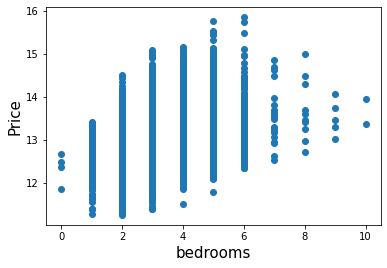

In [22]:
plt.scatter(train["bedrooms"], y)
plt.xlabel('bedrooms', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

완전히 정비례하진 않지만 bedrooms의 수와 가격이 어느정도 상관관계를 보이고 있는것 같습니다.

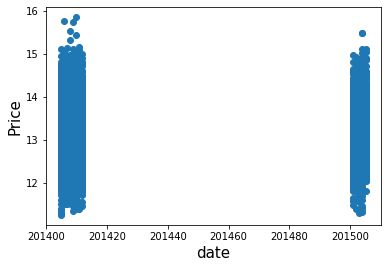

In [23]:
plt.scatter(train["date"], y)
plt.xlabel('date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

반면에 집이 판매된 날짜는 지나치게 한쪽에 몰려있는데다가 가격과는 아무런 연관이 없어보입니다 제거해줍시다.

In [24]:
del train['date']
del test['date']
print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


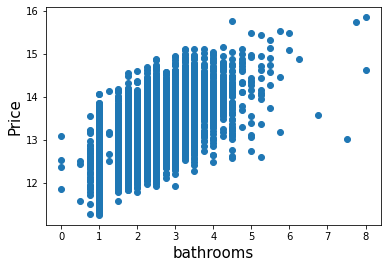

In [25]:
plt.scatter(train["bathrooms"], y)
plt.xlabel('bathrooms', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

욕실의 수와 가격도 거의 비례하는 모습입니다. 이런 식으로 계속 봅시다.

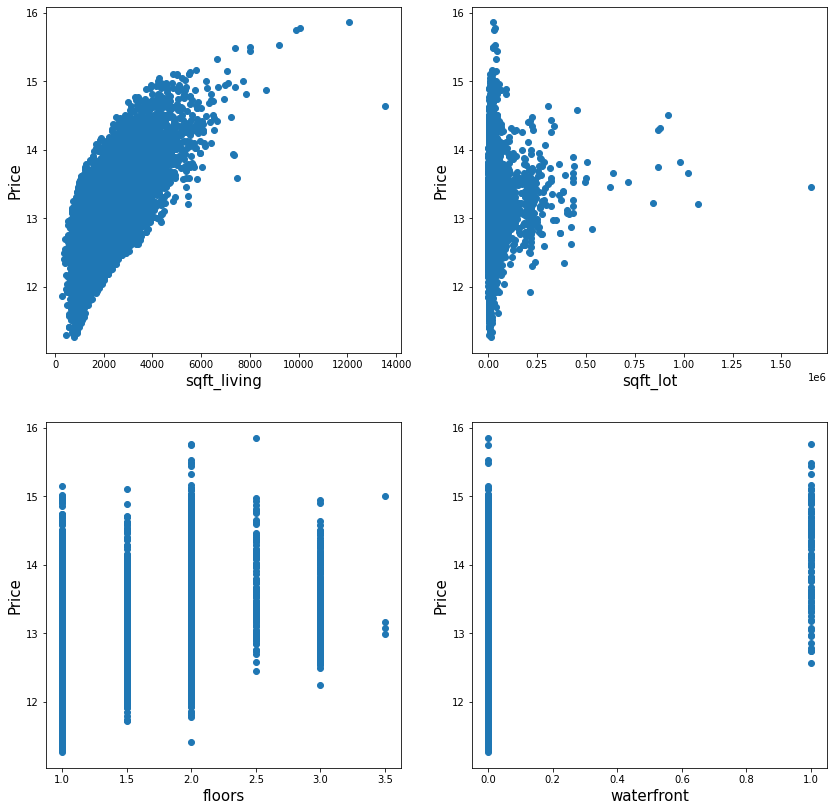

In [26]:
plt.figure(figsize = (14,14))

plt.subplot(221)
plt.scatter(train["sqft_living"], y)
plt.xlabel('sqft_living', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(222)
plt.scatter(train["sqft_lot"], y)
plt.xlabel('sqft_lot', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(223)
plt.scatter(train["floors"], y)
plt.xlabel('floors', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(224)
plt.scatter(train["waterfront"], y)
plt.xlabel('waterfront', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.show()

데이터를 보면 주거공간의 면적은 가격에 큰 영향을 끼치지만, 부지의 면적은 가격과 정비례하지 않는것 같습니다.
무의미한 정보는 아니지만, 극적인 변화를 위해 애매한 데이터는 일단 삭제하고 보겠습니다

In [27]:
del train['sqft_lot']
del test['sqft_lot']
print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')


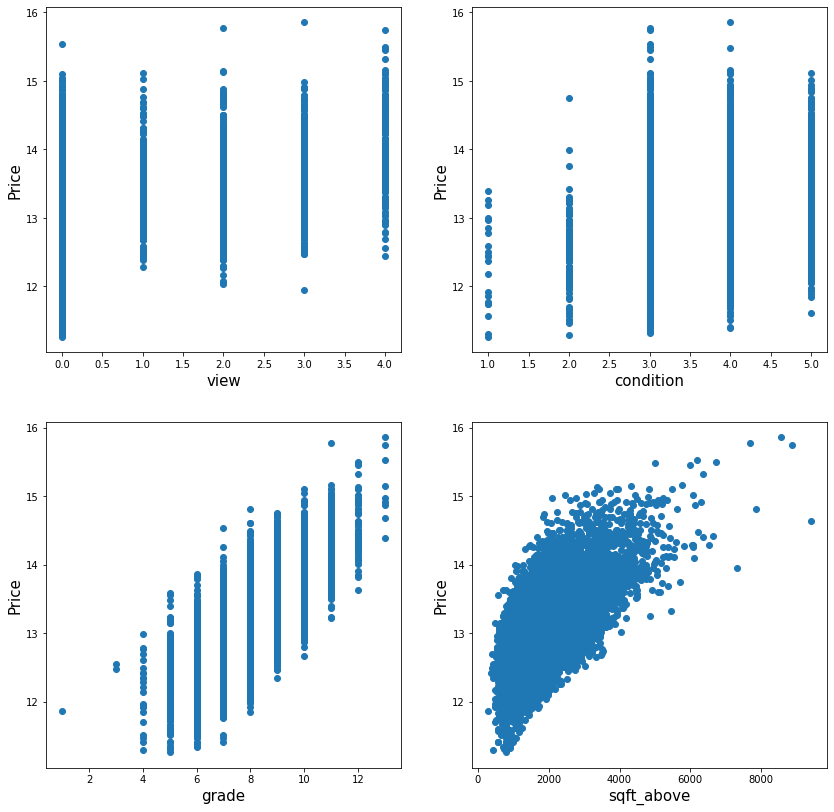

In [28]:
plt.figure(figsize = (14,14))

plt.subplot(221)
plt.scatter(train["view"], y)
plt.xlabel('view', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(222)
plt.scatter(train["condition"], y)
plt.xlabel('condition', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(223)
plt.scatter(train["grade"], y)
plt.xlabel('grade', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(224)
plt.scatter(train["sqft_above"], y)
plt.xlabel('sqft_above', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.show()

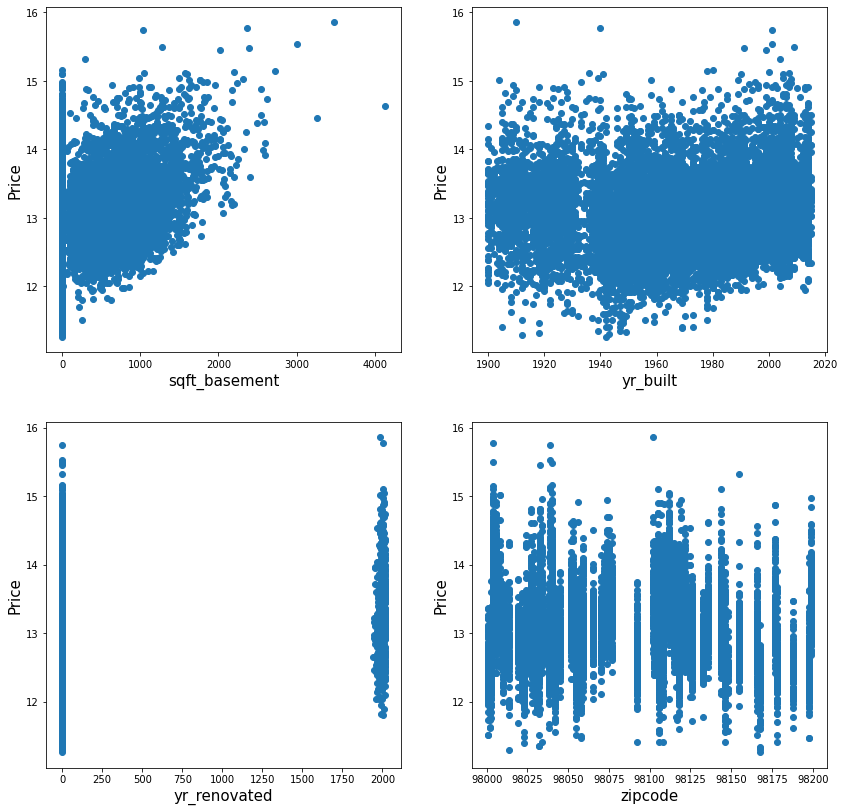

In [29]:
plt.figure(figsize = (14,14))

plt.subplot(221)
plt.scatter(train["sqft_basement"], y)
plt.xlabel('sqft_basement', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(222)
plt.scatter(train["yr_built"], y)
plt.xlabel('yr_built', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(223)
plt.scatter(train["yr_renovated"], y)
plt.xlabel('yr_renovated', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(224)
plt.scatter(train["zipcode"], y)
plt.xlabel('zipcode', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.show()

yr_built(집을 지은 년도)와 zipcode(우편번호)는 가격과 아무런 연관이 없어보입니다  
그런데 yr_renovated(재건축 년도)그래프가 좀 이상하네요  
재건축을 안한집은 0으로 표시해서 그래프를 보기 불편합니다. 데이터를 재가공해주겠습니다.

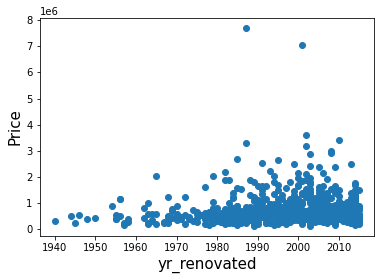

In [30]:
train2=pd.read_csv(train_data_path)

mask = train2['yr_renovated'].isin([0])
train_mask = train2[~mask]
plt.scatter(train_mask["yr_renovated"], train_mask["price"])
plt.xlabel('yr_renovated', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.show()

재건축년도와 가격간에는 어느정도 상관관계가 있는것 같습니다.
yr_built와 zipcode만 제거해줍시다.

In [31]:
del train['yr_built']
del test['yr_built']
del train['zipcode']
del test['zipcode']
print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


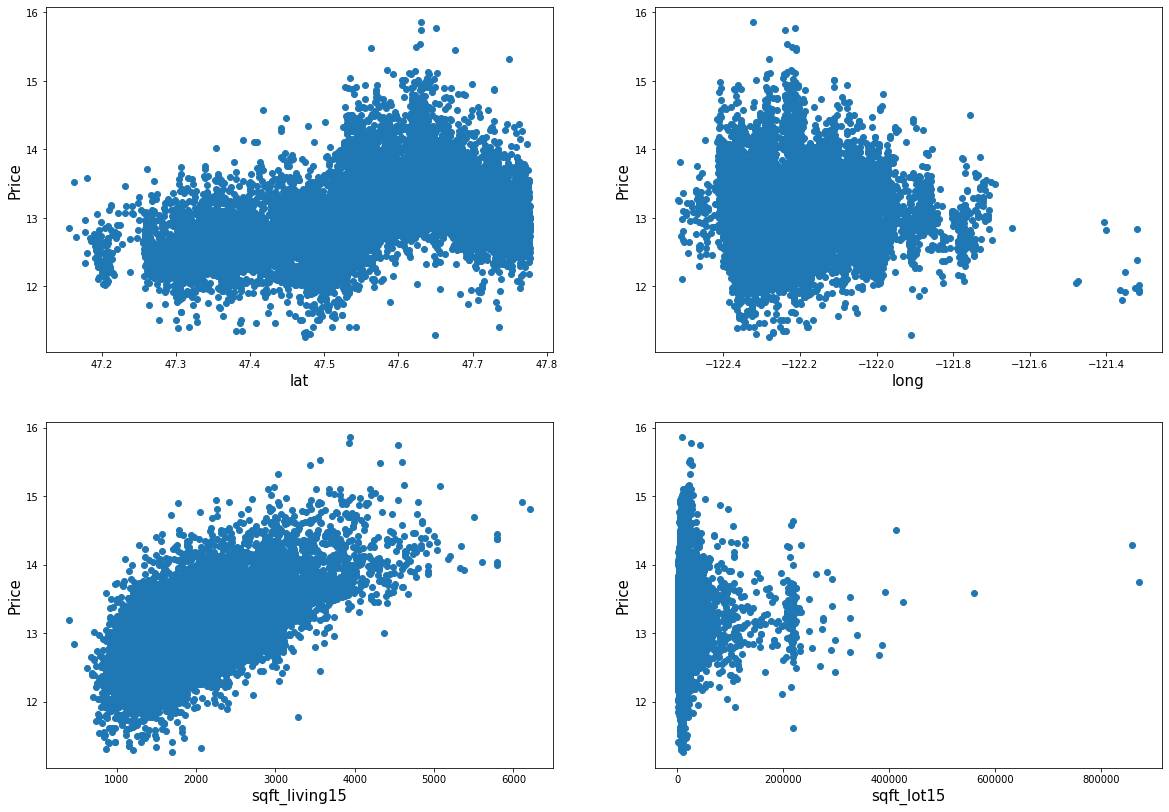

In [32]:
plt.figure(figsize = (20,14))

plt.subplot(221)
plt.scatter(train["lat"], y)
plt.xlabel('lat', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(222)
plt.scatter(train["long"], y)
plt.xlabel('long', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(223)
plt.scatter(train["sqft_living15"], y)
plt.xlabel('sqft_living15', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(224)
plt.scatter(train["sqft_lot15"], y)
plt.xlabel('sqft_lot15', fontsize=15)
plt.ylabel('Price', fontsize=15)


plt.show()

long(경도)은 가격과 큰 연관성이 없어보이지만 lat(위도)은 어느정도 상관관계를 이루는것처럼 보입니다  
lat과 sqft_living15를 제외한 나머지는 제거하겠습니다

In [33]:
del train['long']
del test['long']
del train['sqft_lot15']
del test['sqft_lot15']
print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated',
       'lat', 'sqft_living15'],
      dtype='object')


In [34]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.4s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.039862,0.199655
2,10,50,-0.040452,0.201127
1,1,100,-0.055429,0.235434
0,1,50,-0.073394,0.270914


데이터를 무자비하게 삭제한 결과는?  
RMSLE의 평균값만 더 올랐습니다...  
어디선가 접근방식이 잘못된거 같습니다  

In [35]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.1996')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1996.csv saved!


처음부터 다시 해야겠습니다, 그리드서치로 하이퍼파라미터를 좀더 세세하게 조절해봅시다

In [36]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

sub_id = test['id']
del test['id']

y = train['price']
del train['price']
del train['id']

y = np.log1p(y)

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [37]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    8.6s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
1,0.10,10,150,-0.026458,0.162660
5,0.15,10,150,-0.026578,0.163027
3,0.10,15,150,-0.026605,0.163109
4,0.15,10,100,-0.026855,0.163876
7,0.15,15,150,-0.026951,0.164169
0,0.10,10,100,-0.027027,0.164399
6,0.15,15,100,-0.027167,0.164824
2,0.10,15,100,-0.027174,0.164845


n_estimators 이 올라갈수록, learning rate가 낮아질수록, max depth가 낮아질수록 미세하기 점수가 좋아집니다.  
좀더 낮춰서 테스트해봅시다

In [38]:
param_grid = {
    'n_estimators': [150, 500],
    'max_depth': [10, 5],
    'learning_rate': [0.1, 0.05],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   14.6s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:   18.1s finished


,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.05,10,500,-0.025927,0.161020
1,0.10,10,500,-0.026245,0.162004
3,0.10,5,500,-0.026456,0.162653
0,0.10,10,150,-0.026458,0.162660
7,0.05,5,500,-0.026618,0.163151
4,0.05,10,150,-0.027445,0.165666
2,0.10,5,150,-0.027708,0.166456
6,0.05,5,150,-0.029658,0.172215


max_depth는 10이 최적이라고 생각할 수 있을것 같습니다
n_estimators를 올렸을 때에는 확실히 약간이지만 점수가 좋아졌습니다, 더 화끈하게 세팅해볼까요?

In [39]:
param_grid = {
    'n_estimators': [250, 500],
    'max_depth': [10, 8],
    'learning_rate': [0.08, 0.05],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:   23.3s finished


,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.05,10,500,-0.025927,0.161020
7,0.05,8,500,-0.025982,0.161188
1,0.08,10,500,-0.026072,0.161469
3,0.08,8,500,-0.026122,0.161623
0,0.08,10,250,-0.026156,0.161728
2,0.08,8,250,-0.026171,0.161773
4,0.05,10,250,-0.026496,0.162775
6,0.05,8,250,-0.026660,0.163280


In [40]:
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 12],
    'learning_rate': [0.1, 0.08],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   34.4s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:   42.2s finished


,learning_rate,max_depth,n_estimators,score,RMSLE
4,0.08,10,500,-0.026072,0.161469
6,0.08,12,500,-0.026164,0.161753
0,0.10,10,500,-0.026245,0.162004
2,0.10,12,500,-0.026311,0.162207
5,0.08,10,1000,-0.026402,0.162487
7,0.08,12,1000,-0.026510,0.162820
1,0.10,10,1000,-0.026739,0.163521
3,0.10,12,1000,-0.026790,0.163677


점수는 낮아지고 실행시간만 엄청나게 늘어났습니다.  
일단 최적이었던 하이퍼 파라미터로 케글에 제출해 봅시다.

In [41]:
model = LGBMRegressor(max_depth=10, n_estimators=500, learning_rate=0.05, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.1610')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1610.csv saved!


케글에 제출한 결과 스코어는 112767이 나왔네요  
기준보단 못하지만 조금 나아지긴 했습니다  
위에서 시도한 방법 이외에도 앙상블 기법, 여러 모델에 대한 테스트 역시 시도해봤지만  
코드수준에서 오류가 나서 삭제할수밖에 없었습니다ㅠㅠ  
그리드서치를 이용한 하이퍼파라미터 튜닝으로 성능을 꽤 향상시켰지만 다른사람들이 케글에 올린 커널들을 봤을 때,  
피쳐 엔지니어링이 매우 중요한 포인트인것 같습니다.  
피쳐 엔지니어링을 위한 어떤 통계적 방법론들을 추후에 배워가야겠습니다.  